## Initial Setup

In [ ]:
#pip install keras-cv

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [4]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4, EfficientNetB7, EfficientNetV2M, ResNet50V2, ResNet152V2, InceptionV3, DenseNet121, DenseNet201
import tensorflow as tf
from isic2018_task3_data_preprocessing import DataBalancer, DataPreparer, ModelSpecificProcessor
from isic2018_task3_models import BaseModel
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import keras_cv

## Data Pre-Processing

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/images/'
df['img_path'] = base_path + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [8]:
TARGET_COUNT = 4212
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

balanced_df_list = []
for cls in classes:
    cls_df = df[df[cls] == 1]
    n_samples = len(cls_df)

    if n_samples > TARGET_COUNT:
        # Downsample
        cls_df_balanced = cls_df.sample(TARGET_COUNT, random_state=42)
    elif n_samples < TARGET_COUNT:
        # Upsample
        cls_df_balanced = cls_df.sample(TARGET_COUNT, replace=True, random_state=42)
    else:
        cls_df_balanced = cls_df
    balanced_df_list.append(cls_df_balanced)

df = pd.concat(balanced_df_list).sample(frac=1, random_state=42).reset_index(drop=True)

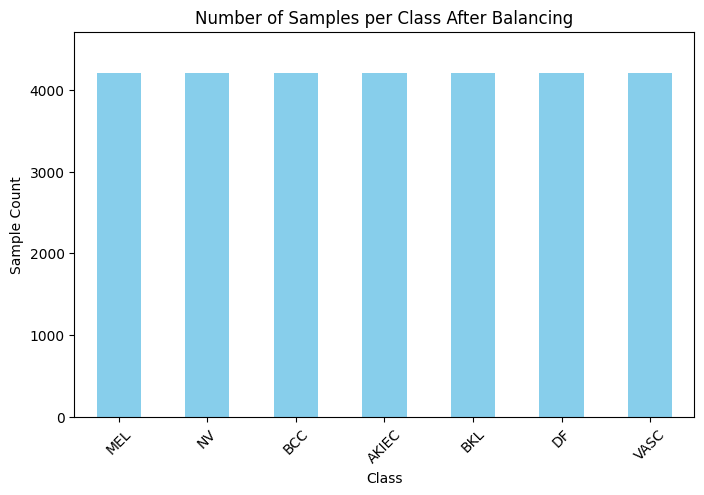

In [9]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [10]:
augmenter = keras.Sequential([
    keras_cv.layers.RandomGaussianBlur(factor=1.0, kernel_size=3),  # Noise reduction
    keras.layers.RandomFlip("horizontal"),                 # Data aug: horizontal flip
    keras.layers.RandomRotation(factor=0.1),               # Data aug: rotation
    keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),  # Data aug: zooming
    keras.layers.RandomShear(x_factor=0.1, y_factor=0.1),   # Data aug: shearing
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training: # Data aug and noise reduction
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224]) # Image resizing
    image = image / 255.0 # Pixel Normalising
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create dataset
df_train = create_dataset(df, training=True)

In [11]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [12]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [13]:
base_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
    )

x = base_model.get_layer('conv5_block3_out').output
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,897,287 (224.68 MB)

 Trainable params: 58,745,863 (224.10 MB)

 Non-trainable params: 151,424 (591.50 KB)

In [15]:
start_time = time.time()
histCNN = model.fit(df_train, epochs=55, validation_data=df_validate)
end_time = time.time()
duration = end_time - start_time
print(f"Model Custom CNN Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 2158s 528ms/step - accuracy: 0.6509 - loss: 0.9826 - val_accuracy: 0.8031 - val_loss: 0.6574
Epoch 2/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 364s 97ms/step - accuracy: 0.8240 - loss: 0.4806 - val_accuracy: 0.8653 - val_loss: 0.4429
Epoch 3/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 365s 97ms/step - accuracy: 0.8634 - loss: 0.3886 - val_accuracy: 0.6218 - val_loss: 2.0614
Epoch 4/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 364s 97ms/step - accuracy: 0.8890 - loss: 0.3009 - val_accuracy: 0.8187 - val_loss: 0.5070
Epoch 5/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 364s 97ms/step - accuracy: 0.9081 - loss: 0.2563 - val_accuracy: 0.8187 - val_loss: 0.5168
Epoch 6/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 364s 97ms/step - accuracy: 0.9249 - loss: 0.2138 - val_accuracy: 0.8135 - val_loss: 0.5869
Epoch 7/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 364s 97ms/step - accuracy: 0.9284 - loss: 0.2004 - val_accuracy: 0.7513 - val_loss: 0.8250
Epoch 8/55
3686/3686 ━━━━━━━━━━━━━━━━━━━━ 364s 97ms/step - accuracy

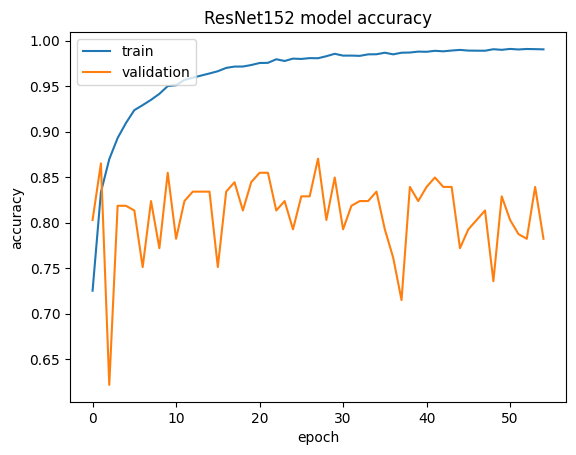

In [20]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(histCNN, "ResNet152")

In [19]:
test_loss, *test_metrics = model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 117s 619ms/step - accuracy: 0.7480 - loss: 1.7016
Test Loss: 2.005000352859497
Test Metrics: [0.7248677015304565]


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


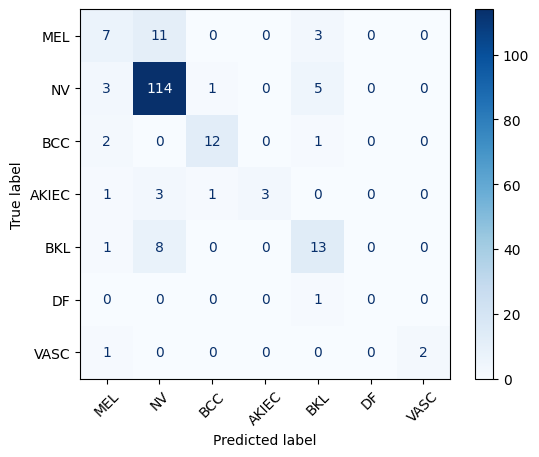

In [18]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [17]:
model_save_name = 'modelRN152Nawaz2025.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
model.save(path)